In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from pickle import dump , load
import pandas as pd
import numpy as np
import os

In [15]:
class PimaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(8, 32)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(32, 64)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(64, 16)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act_output(self.output(x))
        return x
    
    
def load_model(input_folder = './../model_training/model'):
    model = torch.load(input_folder)
    model.eval()
    return model


def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    accuracy = (y_pred.round() == y_test).float().mean()
    return accuracy

    
def create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, seed):
    torch.manual_seed(seed)
    
    model = PimaClassifier()
    batch_size = 128
    loss_fn = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print('accuracy before training {}'.format(accuracy))
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = y_train[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            # print(loss)
            loss.backward()
            optimizer.step()
        # print(loss.tolist())
        # evaluate model on each epoch
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print(f'Finished epoch {epoch},  accuracy {accuracy}')
    return model

def replace_column_values(df, column_name, old_value, new_value):
    if column_name in df.columns:
        df[column_name] = df[column_name].replace(old_value, new_value)
        print(f"All instances of '{old_value}' in column '{column_name}' have been changed to '{new_value}'.")
    else:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
    return df


def create_data(train_df_loc, test_df_loc):
    
    train = pd.read_csv(train_df_loc)
    train.drop(['Unnamed: 0'], axis=1, inplace=True)
    # train = replace_column_values(train, 'class', 2 , 0)
    test = pd.read_csv(test_df_loc)
    test.drop(['Unnamed: 0'], axis=1, inplace=True)
    # test = replace_column_values(test, 'class', 2 , 0)
    
    X_train = train.iloc[:, 0:8].values
    y_train = train.iloc[:, 8].values
    # print(y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = test.iloc[:, 0:8].values
    y_test = test.iloc[:, 8].values
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    return X_train, y_train, X_test, y_test


def create_list_of_model(count, X_train, y_train, X_test, y_test, num_epochs):
    list_of_models = []
    for i in range(count):
        model = create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, i)
        list_of_models.append(model)
    return list_of_models


def eval_model(model, input):
    # print(input)
    model.eval()
    input = torch.tensor(input, dtype=torch.float32)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0]


def evaluate_model_for_df(df , model_list):
    probability_list = []
    if df.shape[0] == 0:
        return 0
    else:
        for index, row in df.iterrows():
            counterfactual_success =[]
            x = row.to_numpy()
            for model in model_list:
                prob = eval_model(model, x)
                if prob > 0.5:
                    counterfactual_success.append(1)
                else:
                    counterfactual_success.append(0)
            probability_list.append(sum(counterfactual_success)/len(counterfactual_success))
        return sum(probability_list)/len(probability_list)

In [16]:
def calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model_list):
    metric_dict = {'dice_robustness' : [],
                   'Our_method_robustness' : [],
                   'certif_robustness' : [],
                   'GE_NSGAII_robustness': []}
    
    output_dict = {}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        
        metric_dict['dice_robustness'].append(evaluate_model_for_df(dice_df, model_list ))
        metric_dict['Our_method_robustness'].append(evaluate_model_for_df(Our_method_df, model_list))
        metric_dict['certif_robustness'].append(evaluate_model_for_df(certif_df, model_list))
        metric_dict['GE_NSGAII_robustness'].append(evaluate_model_for_df(NSGAII_df, model_list))
    
    for key, value in metric_dict.items():
        output_dict[key] = sum(value)/ len(value)
        
        
    return output_dict, metric_dict


In [17]:

model_orig = load_model()

input_data_loc = './../output/NSGAIII/'
dice_loc = 'Dice_cf/'
ge_cf_loc = 'Ge_cf/'
ge_nsga2_loc = 'Ge_NSGAII_cf/'
certif_cf_loc = 'Certif_cf/'
train_df_loc = "./../model_training/train.csv"
test_df_loc = "./../model_training/test.csv"


In [18]:
X_train, y_train, X_test, y_test = create_data(train_df_loc, test_df_loc)

In [19]:
print(X_train.shape, X_test.shape)

torch.Size([614, 8]) torch.Size([154, 8])


In [20]:
list_of_models = create_list_of_model(40, X_train, y_train, X_test, y_test, num_epochs=100)

accuracy before training 0.6623376607894897
Finished epoch 99,  accuracy 0.7142857313156128
accuracy before training 0.3311688303947449
Finished epoch 99,  accuracy 0.6883116960525513
accuracy before training 0.41558441519737244
Finished epoch 99,  accuracy 0.6623376607894897
accuracy before training 0.33766233921051025
Finished epoch 99,  accuracy 0.7142857313156128
accuracy before training 0.6558441519737244
Finished epoch 99,  accuracy 0.6883116960525513
accuracy before training 0.6688311696052551
Finished epoch 99,  accuracy 0.7142857313156128
accuracy before training 0.6363636255264282
Finished epoch 99,  accuracy 0.6818181872367859
accuracy before training 0.6818181872367859
Finished epoch 99,  accuracy 0.7272727489471436
accuracy before training 0.6688311696052551
Finished epoch 99,  accuracy 0.7272727489471436
accuracy before training 0.3311688303947449
Finished epoch 99,  accuracy 0.6818181872367859
accuracy before training 0.3311688303947449
Finished epoch 99,  accuracy 0.701

In [21]:
output_dict, metric_dict = calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, list_of_models)

In [22]:
metric_dict

{'dice_robustness': [0.7638888888888888,
  0.6233072916666665,
  0.6678571428571428,
  0.7814102564102564,
  0.7732142857142857,
  0.8333333333333334,
  0.7579861111111112,
  0.8064285714285713,
  0.8211734693877546,
  0.8510416666666666,
  0.8772727272727274,
  0.8362499999999999,
  0.7518292682926828,
  0.5,
  0.7675,
  0.6716666666666666,
  0.6875,
  0.6437499999999999,
  0.7048780487804878,
  0.8321428571428572,
  0.6871093749999998,
  0.7535714285714287,
  0.6779940119760479,
  0.835,
  0.6699999999999999,
  0.695065789473684,
  0.6125,
  0.6272727272727275,
  0.765,
  0.7187500000000001],
 'Our_method_robustness': [0.49444444444444446,
  0.751953125,
  0.9892857142857142,
  0.7711538461538462,
  0.6642857142857143,
  0.8416666666666667,
  0.5430555555555554,
  0.7888095238095235,
  0.9131802721088427,
  0.8468750000000006,
  0.8659090909090907,
  0.6262500000000001,
  0.7586585365853658,
  1.0,
  0.5935,
  0.9333333333333333,
  0.3,
  0.9,
  0.9359756097560972,
  0.74464285714285

In [23]:
output_dict

{'dice_robustness': 0.7331564639304663,
 'Our_method_robustness': 0.7463324061671451,
 'certif_robustness': 0.5765416666666666,
 'GE_NSGAII_robustness': 0.7380270701678192}

In [24]:
import matplotlib.pyplot as plt

def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

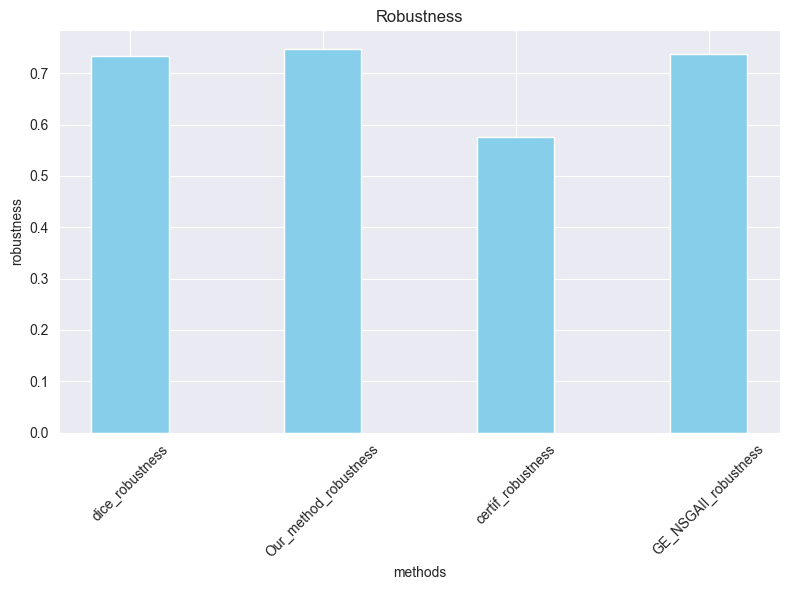

In [25]:
plot_bar_graph(output_dict, title="Robustness", xlabel="methods", ylabel="robustness")